# Классификация персонажей Marvel

## Загрузка библиотек и необходимых модулей

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


## Загрузка данных
Загрузим набор данных `marvel-wikia-data.csv`

In [19]:
# Загрузка данных
df = pd.read_csv("marvel-wikia-data.csv")
print("Размер данных:", df.shape)
df.head()

Размер данных: (16376, 13)


,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,Year
0,1678,Spider-Man (Peter Parker),\/Spider-Man_(Peter_Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,NaN,Living Characters,4043.0,Aug-62,1962.0
1,7139,Captain America (Steven Rogers),\/Captain_America_(Steven_Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,NaN,Living Characters,3360.0,Mar-41,1941.0
2,64786,"Wolverine (James \""Logan\"" Howlett)",\/Wolverine_(James_%22Logan%22_Howlett),Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3061.0,Oct-74,1974.0
3,1868,"Iron Man (Anthony \""Tony\"" Stark)",\/Iron_Man_(Anthony_%22Tony%22_Stark),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2961.0,Mar-63,1963.0
4,2460,Thor (Thor Odinson),\/Thor_(Thor_Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Living Characters,2258.0,Nov-50,1950.0


## Предварительный анализ и отбор целевой переменной
Целевой переменной в данной задаче выберем `SEX` — пол персонажа. Ограничим данные только строками, где явно указан пол (мужской или женский).

In [20]:
# Удалим строки с неопределенным полом
df = df[df['SEX'].isin(['Male Characters', 'Female Characters'])]

## Выбор признаков
Выбираем информативные признаки, которые, по нашему мнению, могут повлиять на пол персонажа, такие как выравнивание, цвет глаз и волос, статус, число появлений и дата первого появления.

In [21]:
# Упрощение и отбор признаков
features = ['ALIGN', 'EYE', 'HAIR', 'GSM', 'ALIVE', 'APPEARANCES', 'FIRST APPEARANCE']
X = df[features]
y = df['SEX']

## Обработка пропусков
Пропущенные значения будут заполнены наиболее частыми (модой) для соответствующего признака.

In [22]:
# Обработка пропусков
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

## Преобразование числовых признаков
- `APPEARANCES`: приводим к числовому типу
- `FIRST APPEARANCE`: извлекаем только год из строки и также приводим к числу

In [23]:
# Обработка числовых признаков
X_imputed['APPEARANCES'] = pd.to_numeric(X_imputed['APPEARANCES'], errors='coerce').fillna(0).astype(int)
X_imputed['FIRST APPEARANCE'] = pd.to_numeric(X_imputed['FIRST APPEARANCE'].str.extract(r'(\d{4})')[0], errors='coerce').fillna(0).astype(int)

## Кодирование признаков
- Категориальные признаки кодируются с помощью `pd.get_dummies`
- Целевая переменная кодируется через `LabelEncoder` (0 — Female, 1 — Male)

In [24]:
# Кодирование категориальных признаков
X_encoded = pd.get_dummies(X_imputed)

## Разделение данных на обучающую и тестовую выборки
Тестовая выборка составит 20% от всего набора. Обучение будет проводиться на 80%.

In [25]:
# Кодирование целевой переменной
y_encoded = LabelEncoder().fit_transform(y)

## Масштабирование признаков
Для метода опорных векторов важно масштабировать признаки. Мы применим `StandardScaler` только к признакам, переданных в SVM.

In [26]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

## Обучение моделей
Мы обучим две модели:
- Support Vector Machine (SVM)
- Random Forest Classifier

In [27]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Модель 1: Метод опорных векторов
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)
svm_preds = svm_model.predict(X_test_scaled)

In [29]:
# Модель 2: Случайный лес
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

## Оценка качества моделей
Оценим модели с использованием метрик:
- **Accuracy** — доля верных предсказаний
- **F1 Score** — гармоническое среднее точности и полноты, особенно важно при дисбалансе классов

In [30]:
# Метрики качества
print("--- SVM ---")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print("F1 Score:", f1_score(y_test, svm_preds))
cm_svm = confusion_matrix(y_test, svm_preds)
print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("F1 Score:", f1_score(y_test, rf_preds))
cm_rf = confusion_matrix(y_test, rf_preds)

--- SVM ---
Accuracy: 0.7618739903069467
F1 Score: 0.858568412972558

--- Random Forest ---
Accuracy: 0.7415185783521809
F1 Score: 0.8405103668261563


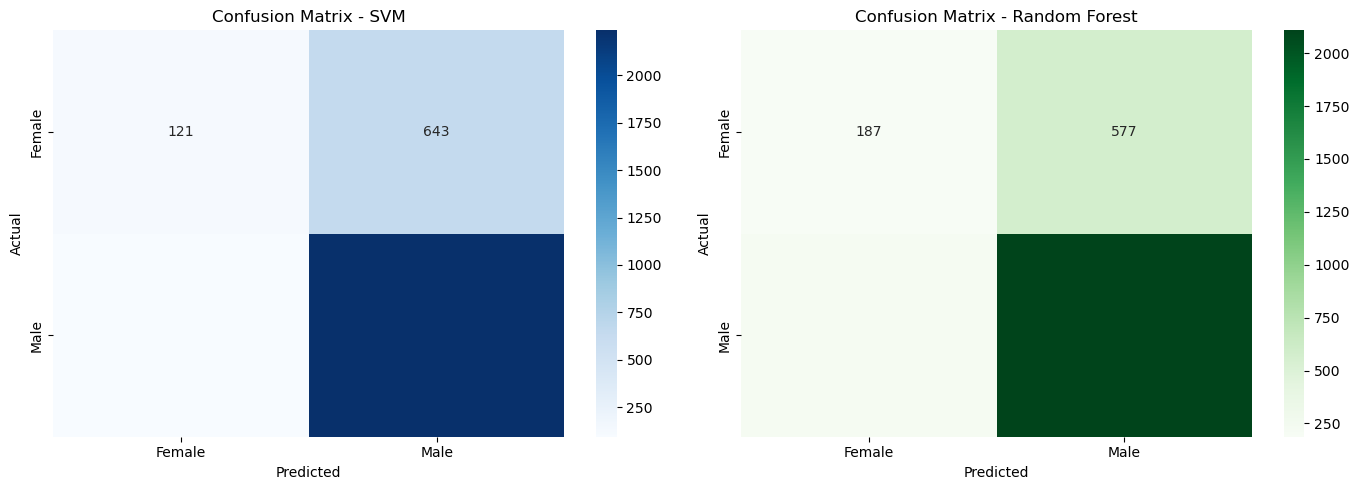

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# SVM
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix - SVM')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_xticklabels(['Female', 'Male'])
axs[0].set_yticklabels(['Female', 'Male'])

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title('Confusion Matrix - Random Forest')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_xticklabels(['Female', 'Male'])
axs[1].set_yticklabels(['Female', 'Male'])

plt.tight_layout()
plt.show()

### Вывод:
- **SVM** обеспечивает лучшее общее качество классификации по метрикам.
- **Random Forest** может быть предпочтительнее, если нужно повысить чувствительность к женским персонажам.
- В условиях дисбаланса классов (больше мужских персонажей), **F1 Score** предпочтительнее для оценки качества.